## Vision Project Walkthrough

In [9]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
imageio.plugins.ffmpeg.download()

RuntimeError: imageio.ffmpeg.download() has been deprecated. Use 'pip install imageio-ffmpeg' instead.'

## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

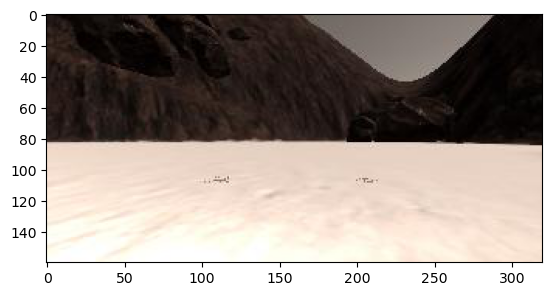

In [10]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list) - 1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

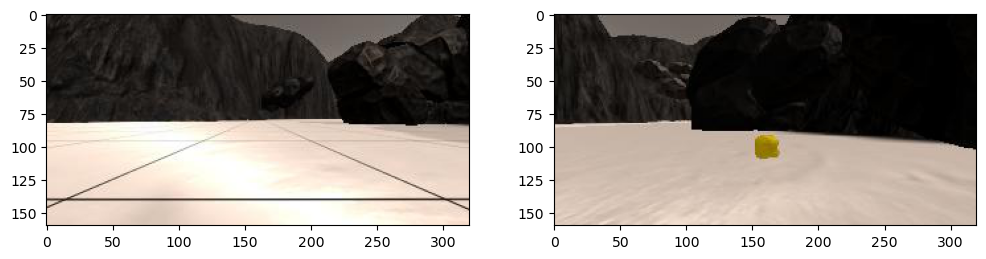

In [11]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = "../calibration_images/example_grid1.jpg"
example_rock = "../calibration_images/example_rock1.jpg"
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

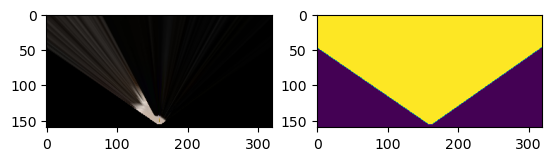

In [12]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    mask = cv2.warpPerspective(np.ones_like(img[:,:,0]),M,(img.shape[1],img.shape[0]))
    return warped,mask

dst = 3
bottom_offset = 5
source = np.float32([[14, 140],
                     [300, 140],
                     [200, 95],
                     [120, 95]])

destination = np.float32([[image.shape[1] / 2 - dst, image.shape[0] - bottom_offset],
                          [image.shape[1] / 2 + dst, image.shape[0] - bottom_offset],
                          [image.shape[1] / 2 + dst, image.shape[0] - 2*dst - bottom_offset],
                          [image.shape[1] / 2 - dst, image.shape[0] - 2*dst - bottom_offset]])


warped,mask = perspect_transform(rock_img, source, destination)
plt.subplot(221)
plt.imshow(warped)
plt.subplot(222)
plt.imshow(mask)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

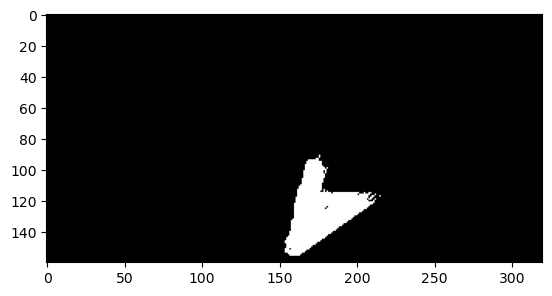

In [33]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:, 0] > rgb_thresh[0]) \
                  &(img[:,:, 1] > rgb_thresh[1]) \
                  &(img[:,:, 2] > rgb_thresh[2])
    
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select
# Used for the video PREP 
def color_rock(img):
  #Finding yellow rock samples
    color_rock = np.zeros_like(img[:,:,0])
    yellow_lower_thresh=(60,60,45)
    yellow_upper_thresh=(255,255,0)
    rock=(img[:,:,0] < yellow_upper_thresh[0]) \
      & (img[:,:,1] < yellow_upper_thresh[1]) \
      & (img[:,:,2] > yellow_upper_thresh[2]) \
      & (img[:,:,0] > yellow_lower_thresh[0]) \
      & (img[:,:,1] > yellow_lower_thresh[1]) \
      & (img[:,:,2] < yellow_lower_thresh[2])
      
    color_rock[rock]=1
    return color_rock
# Used for the video PREP
def color_obstacle(img, ):
  # Finding obstacles
    color_obstacle = np.zeros_like(img[:,:,0])
    upper_thresh=(155, 155, 155)
    lower_thresh=(3,3,3)
    occupied_space=(img[:,:,0] < upper_thresh[0]) \
                & (img[:,:,1] < upper_thresh[1]) \
                & (img[:,:,2] < upper_thresh[2]) \
                & (img[:,:,1] > lower_thresh[0]) \
                & (img[:,:,2] > lower_thresh[1]) \
                & (img[:,:,2] > lower_thresh[2]) 
    color_obstacle[occupied_space]=1
  
    return color_obstacle

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

# Adjust to world Coordinates

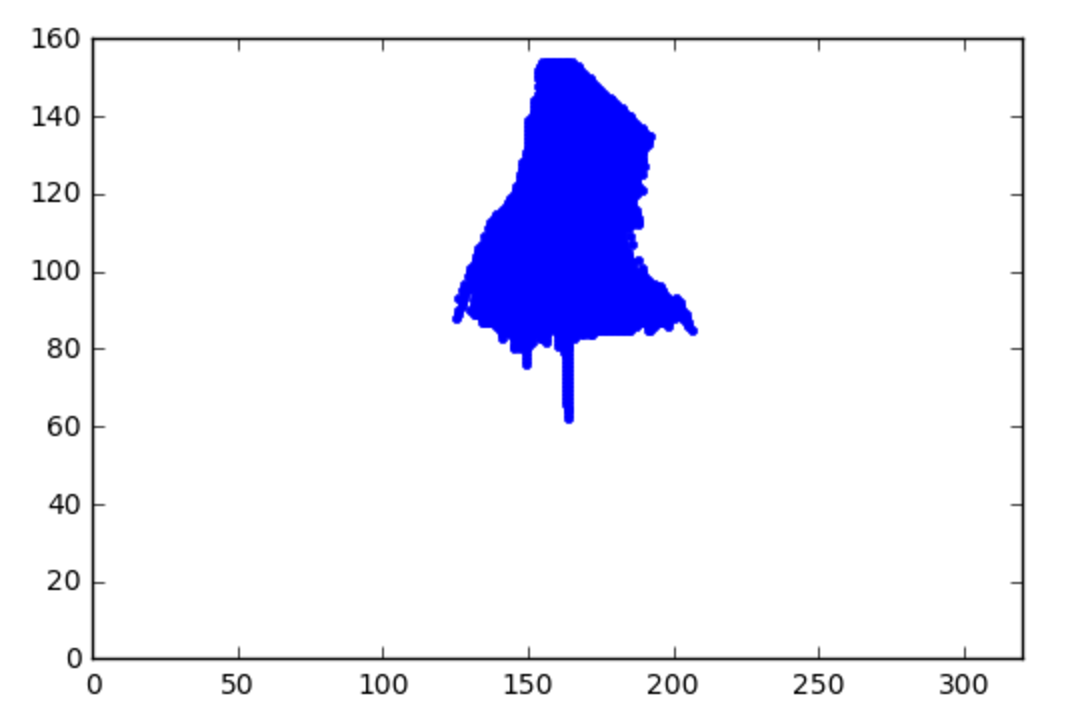

## World Map

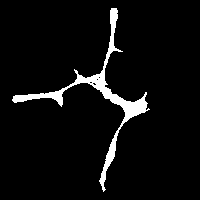

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

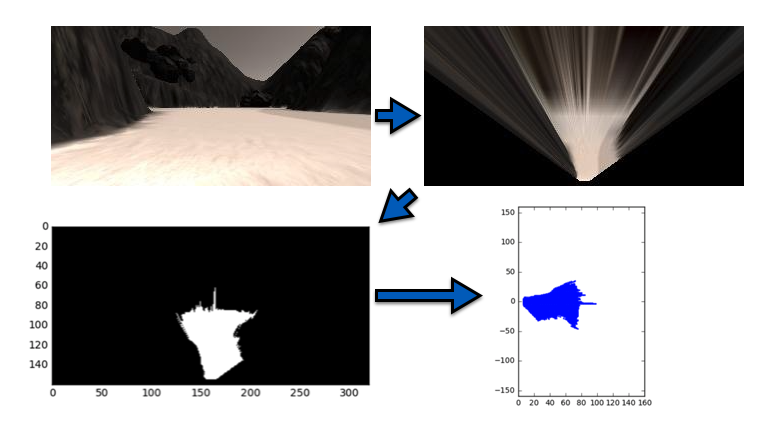

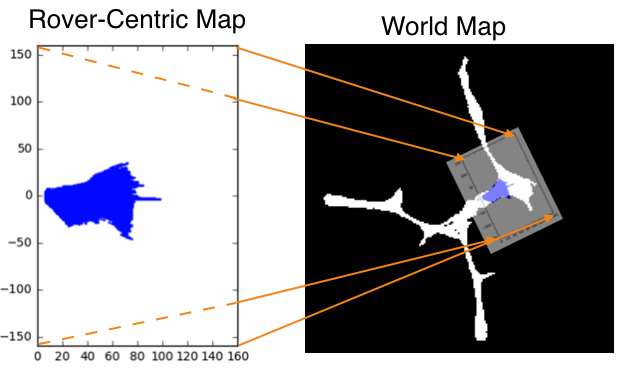

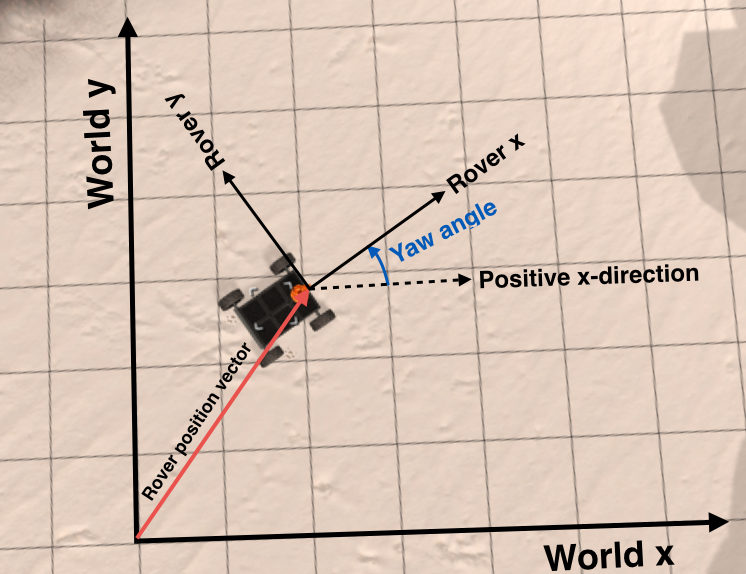

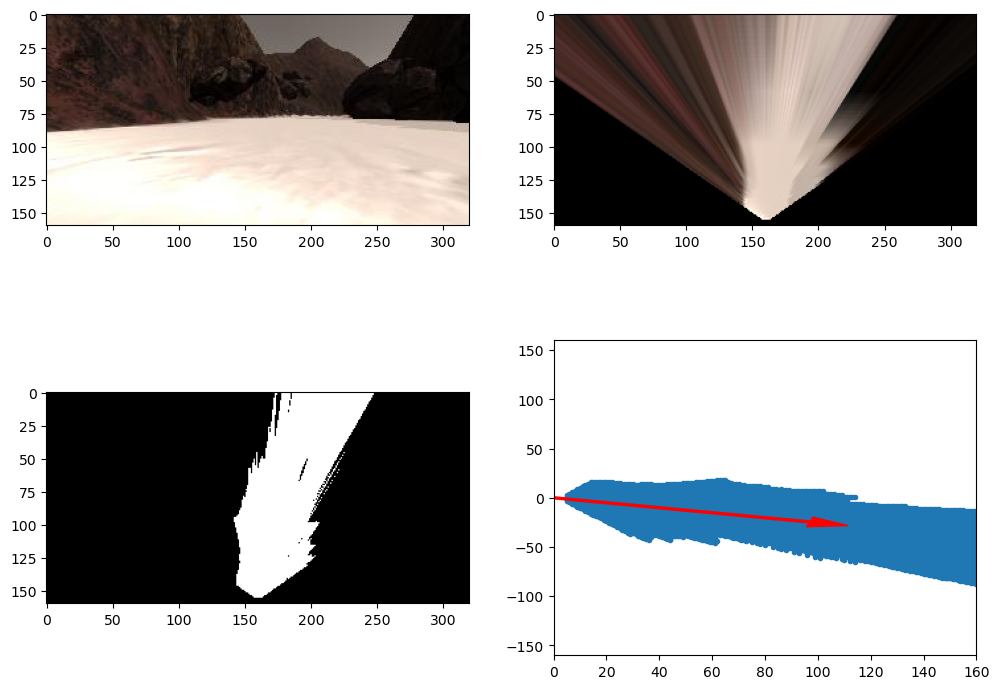

In [34]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel


# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world


# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped ,mask = perspect_transform(image, source, destination)
threshed = color_thresh(warped)
obs_map = np.absolute(np.float32(threshed)-1) * mask

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)



In [35]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change this path to your data directory
df = pd.read_csv('../test_dataset/robot_log.csv')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = -1 # This will be a running index, setting to -1 is a hack
                        # because moviepy (below) seems to run one extra iteration
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap
          
# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


In [45]:
# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])
   
        
    x_rover=data.xpos[data.count]
    y_rover=data.ypos[data.count]
    yaw_rover=data.yaw[data.count]
    # TODO: 
    # 1) Define source and destination points for perspective transform
    dst_size = 7
    bottom_offset = 6
    source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
    # 2) Apply perspective transform
    warped ,mask = perspect_transform(image, source, destination)
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    threshed = color_thresh(warped)
    rock_img=color_rock(warped)
    obstacle_img=color_obstacle(warped)
    # 4) Convert thresholded image pixel values to rover-centric coords
    xpix_navigable, ypix_navigable = rover_coords(threshed)
    xpix_rock, ypix_rock = rover_coords(rock_img)
    xpix_obstacle, ypix_obstacle = rover_coords(obstacle_img)
    # 5) Convert rover-centric pixel values to world coords

    scale=3*dst_size
    world_size=data.worldmap[0].shape[0]  
    navigable_x_world,navigable_y_world=pix_to_world(xpix_navigable, ypix_navigable, x_rover, y_rover, yaw_rover, world_size, scale) 
    rock_x_world,rock_y_world=pix_to_world(xpix_rock, ypix_rock, x_rover, y_rover, yaw_rover, world_size, scale) 
    obstacle_x_world,obstacle_y_world=pix_to_world(xpix_obstacle, ypix_obstacle, x_rover, y_rover, yaw_rover, world_size, scale) 
    # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1
    data.worldmap[obstacle_y_world,obstacle_x_world,0]+=1
    data.worldmap[rock_y_world,rock_x_world,1]+=1
    data.worldmap[navigable_y_world,navigable_x_world,2]+=1
    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
    warped,mask = perspect_transform(img, source, destination)
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)

    
        # Then putting some text over the image
    cv2.putText(output_image,"Robot Status : X "+str(x_rover)+' Y '+str(y_rover)+'YAW '+str(yaw_rover), (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    if (data.count+1<len(data.xpos)):
        data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image


In [46]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

t:   1%|▏                             | 2/283 [19:53<00:39,  7.08it/s, now=None]

Moviepy - Building video ../output/test_mapping.mp4.
Moviepy - Writing video ../output/test_mapping.mp4




t:   1%|▏                             | 2/283 [19:59<00:39,  7.08it/s, now=None]

Moviepy - Done !
Moviepy - video ready ../output/test_mapping.mp4
CPU times: user 2.73 s, sys: 220 ms, total: 2.95 s
Wall time: 6.11 s


In [44]:
from IPython.display import HTML
HTML("""

  {0}">

""".format(output))
